#### DSB-FC Amplitude Modulation 

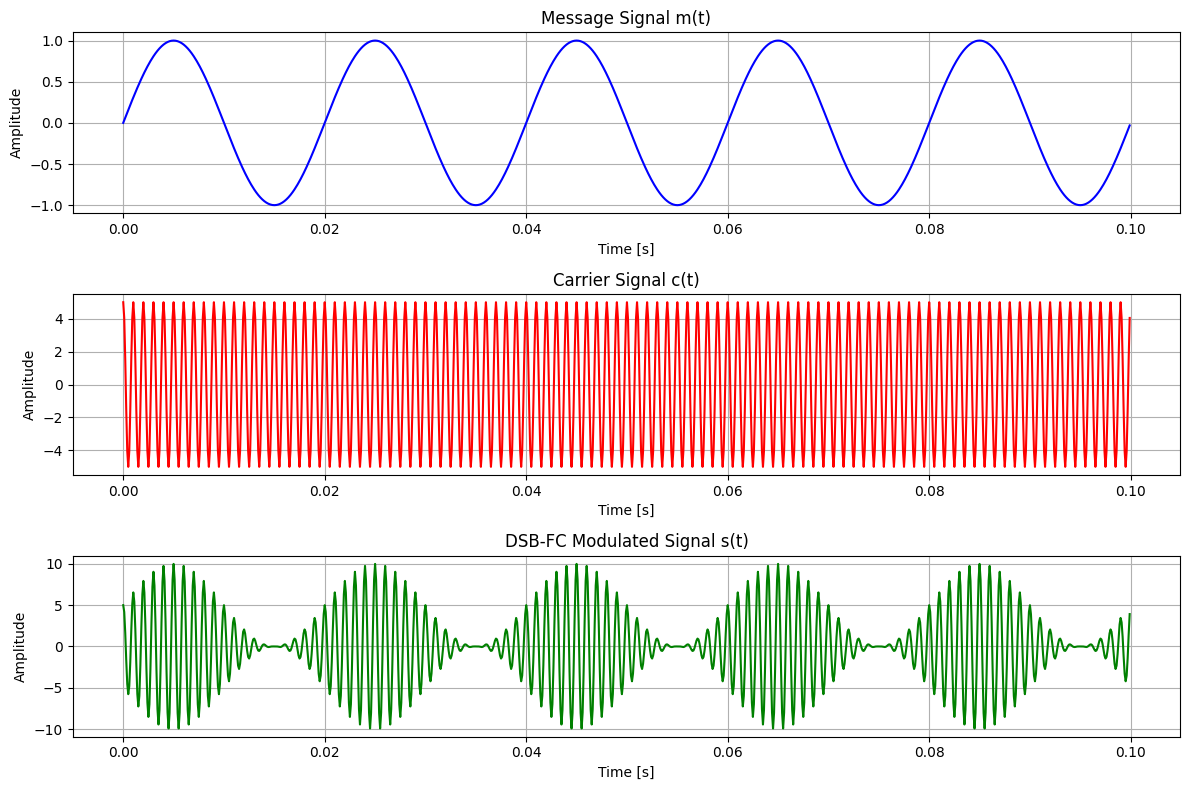

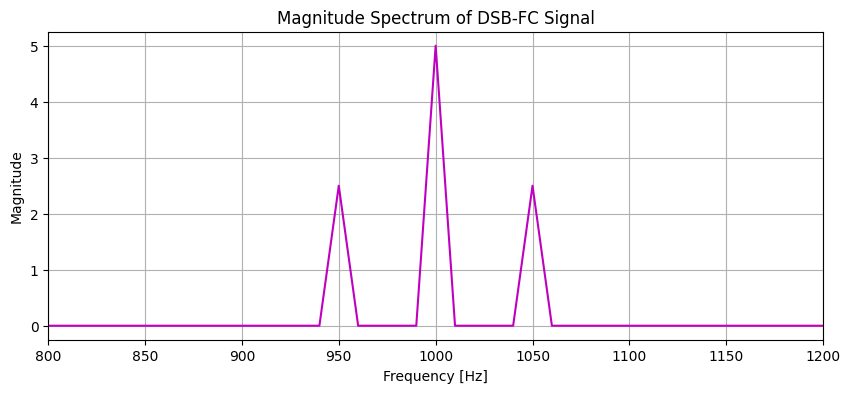

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Defining Sampling Parameters
Fs = 10000                 # Sampling frequency (Hz)
T = 0.1                   # Duration of signal (seconds)
t = np.arange(0, T, 1/Fs)  # Time vector (sampling instances)
ka = 1                     # amplitude sensitivity

# Fs must satisfy Nyquist: Fs > 2*fm

# Baseband Signal (Message Signal)
# Single-tone baseband signal m(t) = Am*cos(2*pi*fm*t)
Am = 1                     # Amplitude of message signal
fm = 50                   # Frequency of message signal (Hz)
m_t = Am * np.sin(2 * np.pi * fm * t)

# Carrier Signal (High-frequency carrier)
Ac = 5                     # Carrier amplitude
fc = 1000                  # Carrier frequency (Hz)
c_t = Ac * np.cos(2 * np.pi * fc * t)

# DSB-FC Modulation (The carrier is transmitted in full)
# Formula: s(t) = Ac * [1 + ka * m(t)] * cos(2*pi*fc*t)
s_dsbfc = Ac * (1 + ka * m_t) * np.cos(2 * np.pi * fc * t)

# Ploting Time-Domain Signals
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.plot(t, m_t, 'b', linewidth=1.5)
plt.title('Message Signal m(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, c_t, 'r', linewidth=1.5)
plt.title('Carrier Signal c(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, s_dsbfc, 'g', linewidth=1.5)
plt.title('DSB-FC Modulated Signal s(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Frequency-Domain Analysis
N = len(s_dsbfc)
S_f = np.fft.fft(s_dsbfc)/N       # FFT and normalization
f = np.fft.fftfreq(N, 1/Fs)       # Frequency axis (can be positive/negative)

f_pos = f[:N//2]                  # Take only positive frequencies
S_f_pos = 2 * np.abs(S_f[:N//2])  # Multiply by 2 to account for symmetry

plt.figure(figsize=(10,4))
plt.plot(f_pos, S_f_pos, 'm', linewidth=1.5)
plt.title("Magnitude Spectrum of DSB-FC Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(fc-200, fc+200)
plt.show()

### DSB-FC Demodulation (Envelope + Coherent)


Demodulation metrics (edge-trimmed):
Envelope detector -> MSE: 0.148289, Correlation: 1.0000
Coherent detector -> MSE: 0.000002, Correlation: 1.0000


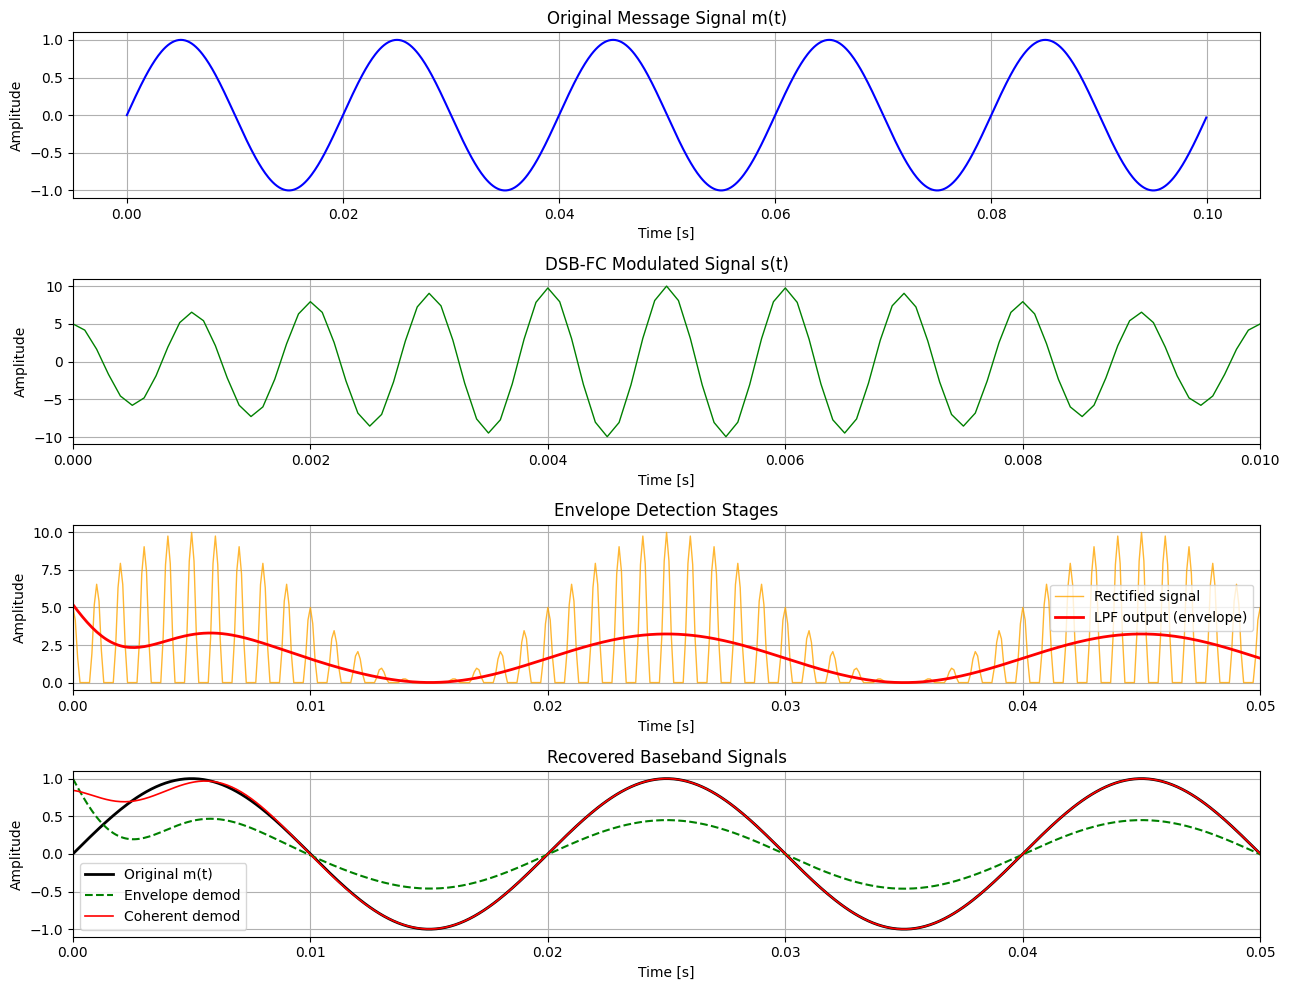

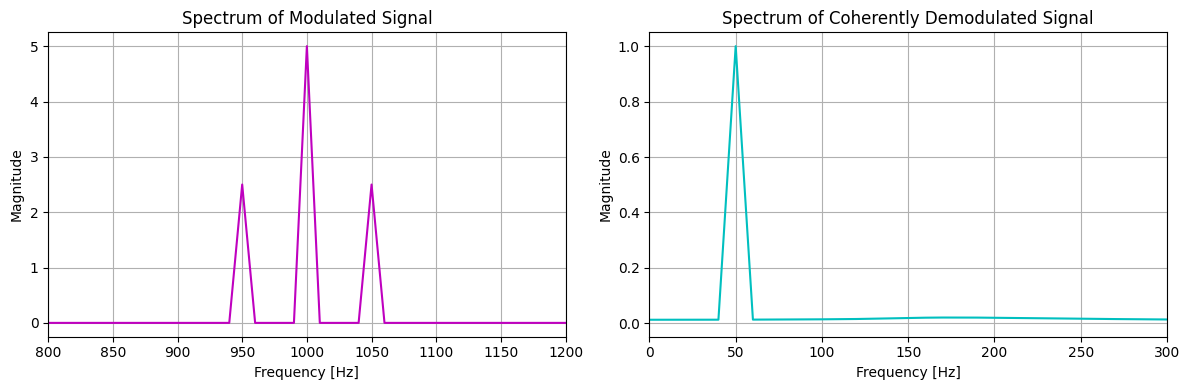

In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

# Low-pass filter for baseband recovery
order = 4
cutoff = 3 * fm
b, a = butter(order, cutoff / (0.5 * Fs), btype="low")

# Envelope detector
# ------------------------------
rectified = np.maximum(s_dsbfc, 0)
envelope = filtfilt(b, a, rectified)

# Remove DC and scale for direct comparison with m(t)
m_env = envelope - np.mean(envelope)
m_env = (Am / np.max(np.abs(m_env))) * m_env

# Coherent (synchronous) detector
# ------------------------------
local_carrier = np.cos(2 * np.pi * fc * t)
mixed = 2 * s_dsbfc * local_carrier
baseband = filtfilt(b, a, mixed)

# LPF{2 s(t) cos(wc t)} = Ac(1 + ka m(t))
m_coh = (baseband - Ac) / (Ac * ka)

# Quantitative comparison
# ------------------------------
edge = int(0.01 * Fs)
valid = slice(edge, -edge if edge > 0 else None)

mse_env = np.mean((m_t[valid] - m_env[valid]) ** 2)
mse_coh = np.mean((m_t[valid] - m_coh[valid]) ** 2)
corr_env = np.corrcoef(m_t[valid], m_env[valid])[0, 1]
corr_coh = np.corrcoef(m_t[valid], m_coh[valid])[0, 1]

print("Demodulation metrics (edge-trimmed):")
print(f"Envelope detector -> MSE:" f"{mse_env:.6f}, Correlation: {corr_env:.4f}")
print(f"Coherent detector -> MSE:" f"{mse_coh:.6f}, Correlation: {corr_coh:.4f}")

# Time-domain plots
# ------------------------------
plt.figure(figsize=(13, 10))

plt.subplot(4, 1, 1)
plt.plot(t, m_t, "b", linewidth=1.5)
plt.title("Original Message Signal m(t)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, s_dsbfc, "g", linewidth=1.0)
plt.title("DSB-FC Modulated Signal s(t)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.01)  # zoom to see carrier cycles
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(
    t,
    rectified,
    color="orange",
    linewidth=1.0,
    alpha=0.8,
    label="Rectified signal",
)
plt.plot(t, envelope, "r", linewidth=2, label="LPF output (envelope)")
plt.title("Envelope Detection Stages")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.05)
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, m_t, "k", linewidth=2, label="Original m(t)")
plt.plot(t, m_env, "g--", linewidth=1.5, label="Envelope demod")
plt.plot(t, m_coh, "r", linewidth=1.2, label="Coherent demod")
plt.title("Recovered Baseband Signals")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.05)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Frequency-domain view
# ------------------------------
N = len(s_dsbfc)
f = np.fft.fftfreq(N, 1 / Fs)

S = np.fft.fft(s_dsbfc) / N
Mcoh = np.fft.fft(m_coh) / N

pos = f >= 0
f_pos = f[pos]
S_pos = 2 * np.abs(S[pos])
Mcoh_pos = 2 * np.abs(Mcoh[pos])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(f_pos, S_pos, "m", linewidth=1.5)
plt.title("Spectrum of Modulated Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(fc - 200, fc + 200)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(f_pos, Mcoh_pos, "c", linewidth=1.5)
plt.title("Spectrum of Coherently Demodulated Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 300)
plt.grid(True)

plt.tight_layout()
plt.show()

### Effect due to modulation index

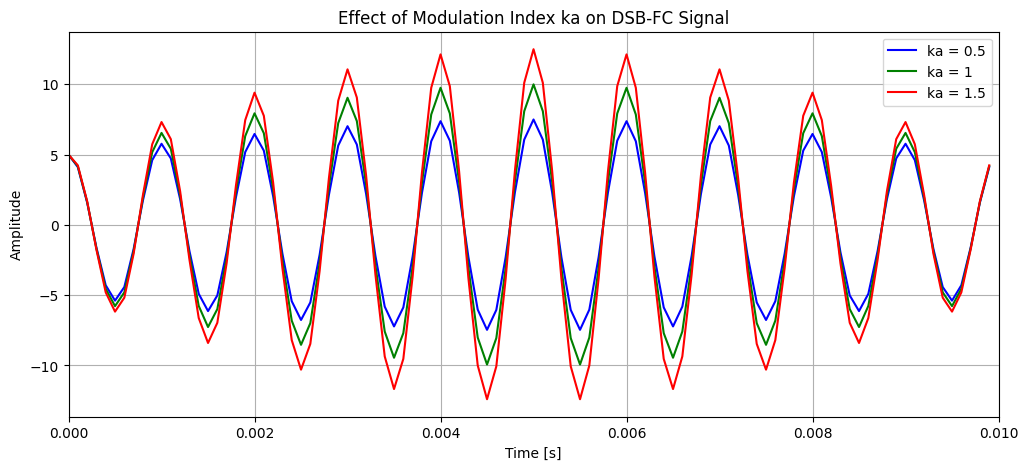

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
Fs = 10000
T = 0.01
t = np.arange(0, T, 1/Fs)

# Baseband signal
Am = 1
fm = 50
m_t = Am * np.sin(2 * np.pi * fm * t)

# Carrier
Ac = 5
fc = 1000
c_t = Ac * np.cos(2 * np.pi * fc * t)

# Different ka values
ka_values = [0.5, 1, 1.5]
colors = ['b', 'g', 'r']

plt.figure(figsize=(12,5))

for i, ka in enumerate(ka_values):
    s_dsbfc = Ac * (1 + ka * m_t) * np.cos(2 * np.pi * fc * t)
    plt.plot(t, s_dsbfc, colors[i], label=f'ka = {ka}')

plt.title("Effect of Modulation Index ka on DSB-FC Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0, 0.01)  # small window to clearly see carrier oscillations
plt.show()


### Effect due to message amplitude

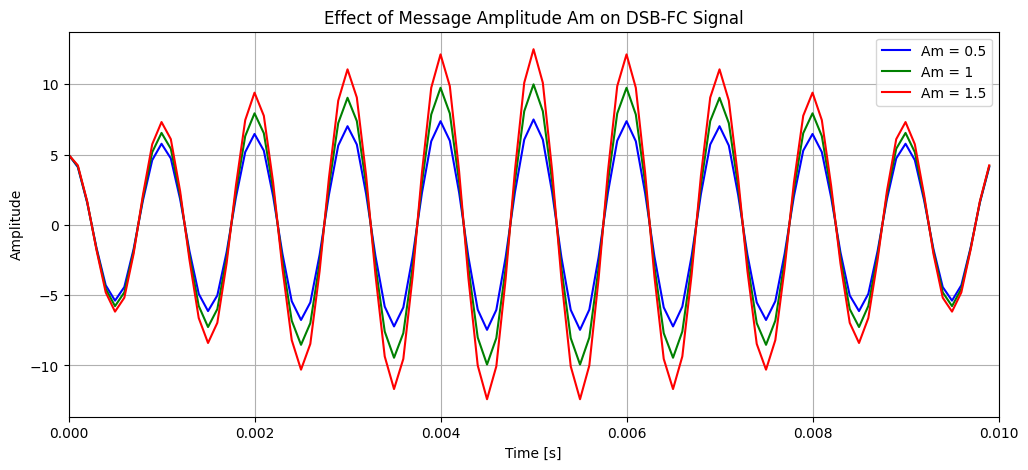

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
Fs = 10000
T = 0.01
t = np.arange(0, T, 1/Fs)

# Carrier
Ac = 5
fc = 1000
c_t = Ac * np.cos(2 * np.pi * fc * t)

# Different Am values
Am_values = [0.5, 1, 1.5]
ka = 1
colors = ['b', 'g', 'r']

# Baseband signal and DSB-FC modulation for each Am
plt.figure(figsize=(12,5))

for i, Am in enumerate(Am_values):
    m_t = Am * np.sin(2 * np.pi * 50 * t)  # message frequency fm = 50 Hz
    s_dsbfc = Ac * (1 + ka * m_t) * np.cos(2 * np.pi * fc * t)
    plt.plot(t, s_dsbfc, colors[i], label=f'Am = {Am}')

plt.title("Effect of Message Amplitude Am on DSB-FC Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0, 0.01)  # small window for clarity
plt.show()

### Effect due to frequency amplitude

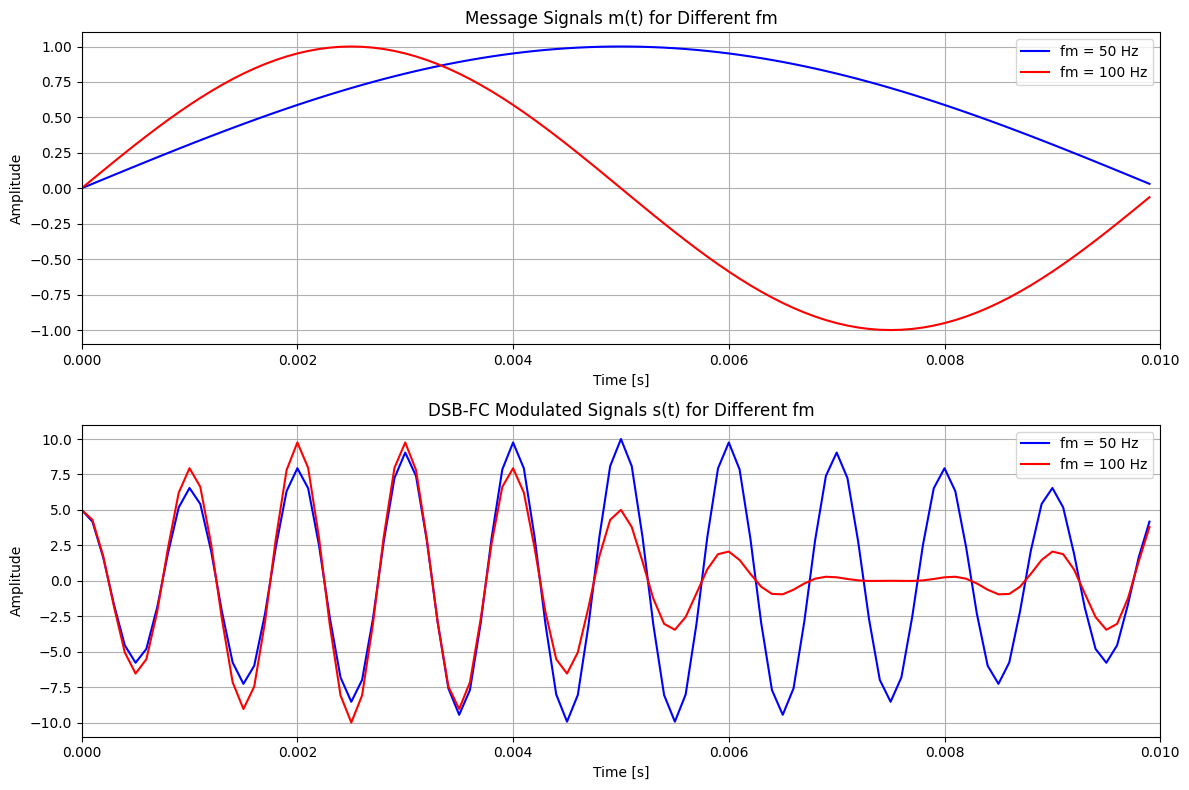

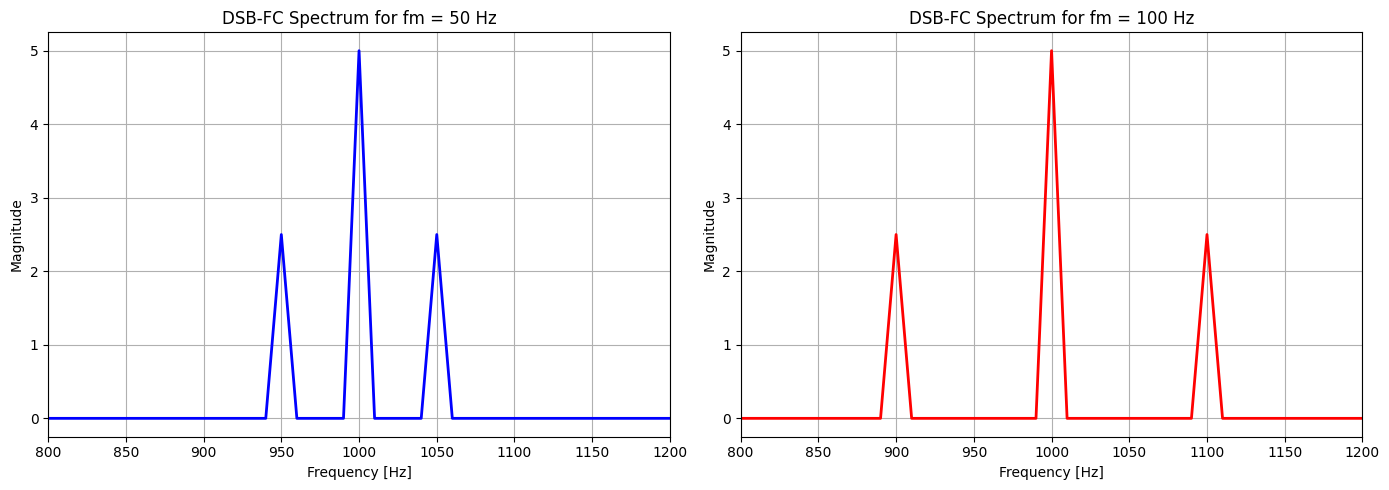

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
Fs = 10000
T = 0.01
t = np.arange(0, T, 1/Fs)

# Carrier and modulation parameters
Ac = 5
ka = 1
Am = 1
fc = 1000

# Message frequencies to compare
fm_values = [50, 100]
colors = ['b', 'r']

plt.figure(figsize=(12,8))

# First subplot: message signals
plt.subplot(2,1,1)
for i, fm in enumerate(fm_values):
    m_t = Am * np.sin(2 * np.pi * fm * t)
    plt.plot(t, m_t, colors[i], label=f'fm = {fm} Hz')
plt.title("Message Signals m(t) for Different fm")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0, 0.01)

# Second subplot: DSB-FC modulated signals
plt.subplot(2,1,2)
for i, fm in enumerate(fm_values):
    m_t = Am * np.sin(2 * np.pi * fm * t)
    s_dsbfc = Ac * (1 + ka * m_t) * np.cos(2 * np.pi * fc * t)
    plt.plot(t, s_dsbfc, colors[i], label=f'fm = {fm} Hz')
plt.title("DSB-FC Modulated Signals s(t) for Different fm")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0, 0.01)

plt.tight_layout()
plt.show()

# Use longer duration for better FFT resolution
T = 0.1  # 0.1 s instead of 0.01 s
t = np.arange(0, T, 1/Fs)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

for i, fm in enumerate(fm_values):
    # Message and DSB-FC signal
    m_t = Am * np.sin(2 * np.pi * fm * t)
    s_dsbfc = Ac * (1 + ka * m_t) * np.cos(2 * np.pi * fc * t)
    
    # FFT
    N = len(s_dsbfc)
    S_f = np.fft.fft(s_dsbfc)/N
    f = np.fft.fftfreq(N, 1/Fs)
    f_pos = f[:N//2]
    S_f_pos = 2 * np.abs(S_f[:N//2])
    
    # Plot on the corresponding subplot
    axs[i].plot(f_pos, S_f_pos, colors[i], linewidth=2)
    axs[i].set_title(f"DSB-FC Spectrum for fm = {fm} Hz")
    axs[i].set_xlabel("Frequency [Hz]")
    axs[i].set_ylabel("Magnitude")
    axs[i].grid(True)
    axs[i].set_xlim(fc - 200, fc + 200)  # zoom around carrier

plt.tight_layout()
plt.show()